In [1]:
%load_ext autoreload
%aimport tensor_toolbox
%autoreload 1

# Getting started with neural networks: Classification and regression

## Classifying movie reviews: A binary classification example

### The IMDB dataset

**Listing 4.1: Loading the IMDB dataset**

In [2]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)
# These are arrays of lists! Ugh

**Listing 4.2: Decoding reviews back to text**

In [3]:
word_index = imdb.get_word_index()
def read_review (review, word_index):
    reverse_word_index = dict(
        [(value, key) for (key, value) in word_index.items()])
    return " ".join(
        [reverse_word_index.get(i - 3, "?") for i in review])
read_review(train_data[1], word_index) # Interesting review

"? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ? the hair is big lots of boobs ? men wear those cut ? shirts that show off their ? sickening that men actually wore them and the music is just ? trash that plays over and over again in almost every scene there is trashy music boobs and ? taking away bodies and the gym still doesn't close for ? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

### Preparing the data

**Listing 4.3: Encoding the integer sequences via multi-hot encoding**

In [4]:
import numpy as np
# It's important to note that by doing this, the concept of order is lost. The list previously had added meaning by
# containing the order of the words. The vectorized interpretation only contains the presence of the word.
# Therefore, it is impossible to get the sentence again from the vectorized form!
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1. # Sparse representation of the data
            # For each entry, we will obtain a 10000-dimensional vector with 1s and 0s
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

In [5]:
tensor_toolbox.tensor_info(x_train, "x_train", image=False)
tensor_toolbox.tensor_info(train_labels, "train_labels")

==================== x_train | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (25000, 10000) | nDims: 2 | dtype: float64
x_train[0]: [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
... (showing only the first 20 elements)

==================== train_labels | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (25000,) | nDims: 1 | dtype: int64
Content: [1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]
... (showing only the first 20 elements)



### Building your model

**Listing 4.4: Model definition**

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [7]:
# PyTorch:
import torch
class TorchModel (torch.nn.Module):
    def __init__(self):
        super().__init__()
        # This layer is lazy, it will only be created when the model is
        # first run. Kind of similar to how Keras works.
        self.fc1 = torch.nn.LazyLinear(16)
        self.fc2 = torch.nn.Linear(16, 16)
        self.fc3 = torch.nn.Linear(16, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

torchmodel = TorchModel()

/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


**Listing 4.5: Compiling the model**

In [7]:
model.compile(optimizer="rmsprop", # rmsprop is a good default optimizer
              loss="binary_crossentropy", # binary_crossentropy is a good default loss function for binary classification
              metrics=["accuracy"])

In [9]:
optimizer = torch.optim.RMSprop(torchmodel.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss from raw logits. Better for numerical stability.
# For computing the loss, we are in a conundrum:
# It gets reduced to a scalar by computing the batch average.
# However, to be able to compute the average epoch loss, we need to
# accumulate the loss without averaging it.
# There are two options: either we multiply it back by the batch size
# before accumulating it and after updating the weights,
# or we keep it from reducing using 'reduction=none'. Then, we would
# have to manually divide it by the batch size while computing the
# gradient! I prefer approach 1.

def torchtrain (model, train_dataloader, optimizer, loss_fn):
    model.train() # Set training mode for the model
    # Initialize metrics
    total_loss = 0.0
    correct = 0
    samples = 0

    for X, y in train_dataloader: # Iterate over the batches
        # Forward pass
        y_hat = torch.flatten(model(X)) # I flatten it because the output has shape (batch_size, 1)
        # You can also use unsqueeze to add a dimension to the targets.

        loss = loss_fn(y_hat, y) # Calculate the loss

        # Backprop
        optimizer.zero_grad() # Zero the gradients
        loss.backward() # Calculate the gradients
        optimizer.step() # Update the weights

        # Metrics
        total_loss += loss.item()*len(X) # Loss value!
        # The expression y_hat.round() == y returns a tensor with shape
        # 512x1 with True/False values. sum() will sum the True values.
        # item() will convert the tensor to a Python number.

        # Keep in mind that, using BCEwithLogitsLoss, the output is not a probability!
        # To be able to compute accuracy, we will need to run it through a sigmoid and then
        # round it.
        correct += ((torch.sigmoid(y_hat).round()) == y).sum().item()
        samples += len(y) # Items in the batch

    avg_loss = total_loss / len(train_dataloader.dataset)
    return avg_loss, correct / samples # Accuracy and loss

def torchtest (model, test_dataloader, loss_fn):
    model.eval() # Set evaluation mode
    # Initialize metrics
    total_loss = 0.0
    correct = 0
    samples = 0

    with torch.no_grad(): # Disable gradient calculation
        for X, y in test_dataloader: # Iterate over the batches
            y_hat = torch.flatten(model(X)) # Forward pass. Flatten to get shape (512)
            loss = loss_fn(y_hat, y) # Calculate the loss
            # Metrics
            total_loss += loss.item()*len(X) # Loss value
            correct += (torch.sigmoid(y_hat.round()) == y).sum().item() # Correct count (with sigmoid)
            samples += len(y) # Items in the batch
    avg_loss = total_loss / len(test_dataloader.dataset)
    return avg_loss, correct / samples

### Validating your approach

**Listing 4.6: Setting aside a validation set**

In [8]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

# Or, in scikit:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=10000)

In [11]:
# Let's build two PyTorch dataloaders to hold the data
train_dataloader = tensor_toolbox.make_dataloader([x_train], [y_train], batch_size=512, shuffle=False)
val_dataloader = tensor_toolbox.make_dataloader([x_val], [y_val], batch_size=512, shuffle=False)
tensor_toolbox.tensor_info(train_dataloader, "train_dataloader", image=False)
tensor_toolbox.tensor_info(val_dataloader, "val_dataloader", image=False)

==================== train_dataloader | tensor_info ====================
Type: <class 'torch.utils.data.dataloader.DataLoader'>
Batch size: 512 | N batches: 30 
-- First batch of features
Type: <class 'torch.Tensor'>
Shape: torch.Size([512, 10000]) | nDims: 2 | dtype: torch.float32
features[0]: tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
        1., 1.])
... (showing only the first 20 elements)

-- First batch of labels
Type: <class 'torch.Tensor'>
Shape: torch.Size([512]) | nDims: 1 | dtype: torch.float32
Content: tensor([1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
        1., 1.])
... (showing only the first 20 elements)


==================== val_dataloader | tensor_info ====================
Type: <class 'torch.utils.data.dataloader.DataLoader'>
Batch size: 512 | N batches: 20 
-- First batch of features
Type: <class 'torch.Tensor'>
Shape: torch.Size([512, 10000]) | nDims: 2 | dtype: torch.float32
features[0]: tensor([0

**Annex: Propagations in PyTorch, Binary Cross Entropy**

In [12]:
# The moment has come to look into the shapes of the info flow in PyTorch. 
# Let's select a single sample, and propagate it through the model.
first_batch = next(iter(train_dataloader))
first_batch_input = first_batch[0]
first_batch_labels = first_batch[1]
tensor_toolbox.tensor_info(first_batch_input, "first_batch_input", image=False)
tensor_toolbox.tensor_info(first_batch_labels, "first_batch_labels", image=False)

==================== first_batch_input | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([512, 10000]) | nDims: 2 | dtype: torch.float32
first_batch_input[0]: tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
        1., 1.])
... (showing only the first 20 elements)

==================== first_batch_labels | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([512]) | nDims: 1 | dtype: torch.float32
Content: tensor([1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
        1., 1.])
... (showing only the first 20 elements)



In [13]:
# It's key to see that even though a batch consists of 512 samples, it is only
# one tensor! This is because the model is designed to handle batches, and
# the operations get vectorized. 
first_batch_output = torchmodel(first_batch_input)
tensor_toolbox.tensor_info(first_batch_output, "first_batch_output", image=False)
# The shapes are different! Y is 512 Sized and yhat is 512x1 sized. 
# Let's fix it.
first_batch_labels_expanded = first_batch_labels.unsqueeze(1)
tensor_toolbox.tensor_info(first_batch_labels_expanded, "first_batch_label unsqueezed", image=False)

first_batch_loss = loss_fn(first_batch_output, first_batch_labels_expanded) # If reduction is 'mean'
# (which is default), the loss is averaged over the batch. Therefore, the loss is a scalar tensor!

tensor_toolbox.tensor_info(first_batch_loss, "first_batch_loss", image=False)

==================== first_batch_output | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([512, 1]) | nDims: 2 | dtype: torch.float32
Content: tensor([0.4942, 0.4971, 0.4973, 0.4998, 0.4956, 0.4976, 0.4961, 0.4960, 0.4954,
        0.4968, 0.4982, 0.4940, 0.4968, 0.4972, 0.4949, 0.4955, 0.4949, 0.4944,
        0.4951, 0.4941], grad_fn=<ViewBackward0>)
... (showing only the first 20 elements)

==================== first_batch_label unsqueezed | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([512, 1]) | nDims: 2 | dtype: torch.float32
Content: tensor([1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
        1., 1.])
... (showing only the first 20 elements)

==================== first_batch_loss | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([]) | nDims: 0 | dtype: torch.float32
Content: 0.692478597164154



/Users/alemalvarez/code-workspace/dl-with-python-pytorch/tensor_toolbox.py:89: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  if(tensor.requires_grad and tensor.grad is not None):


In [14]:
# Let's compute the number of correct labels for accuracy calculations:
# In this case, as y is a 512x1 tensor, it is easier to sum the correct guesses by
# comparing element-wise and adding the results.
first_batch_correct = ((first_batch_output.round()) == first_batch_labels_expanded)
tensor_toolbox.tensor_info(first_batch_correct, "first_batch_correct raw", image=False)
first_batch_correct = first_batch_correct.sum()
tensor_toolbox.tensor_info(first_batch_correct, "first_batch_correct", image=False)


==================== first_batch_correct raw | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([512, 1]) | nDims: 2 | dtype: torch.bool
Content: tensor([False,  True, False,  True,  True,  True, False, False,  True,  True,
         True,  True, False, False, False,  True,  True, False, False, False])
... (showing only the first 20 elements)

==================== first_batch_correct | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([]) | nDims: 0 | dtype: torch.int64
Content: 277



**Listing 4.7: Training your model**

In [9]:
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import TensorBoard

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1), 
                               TensorBoard(log_dir="logs")])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

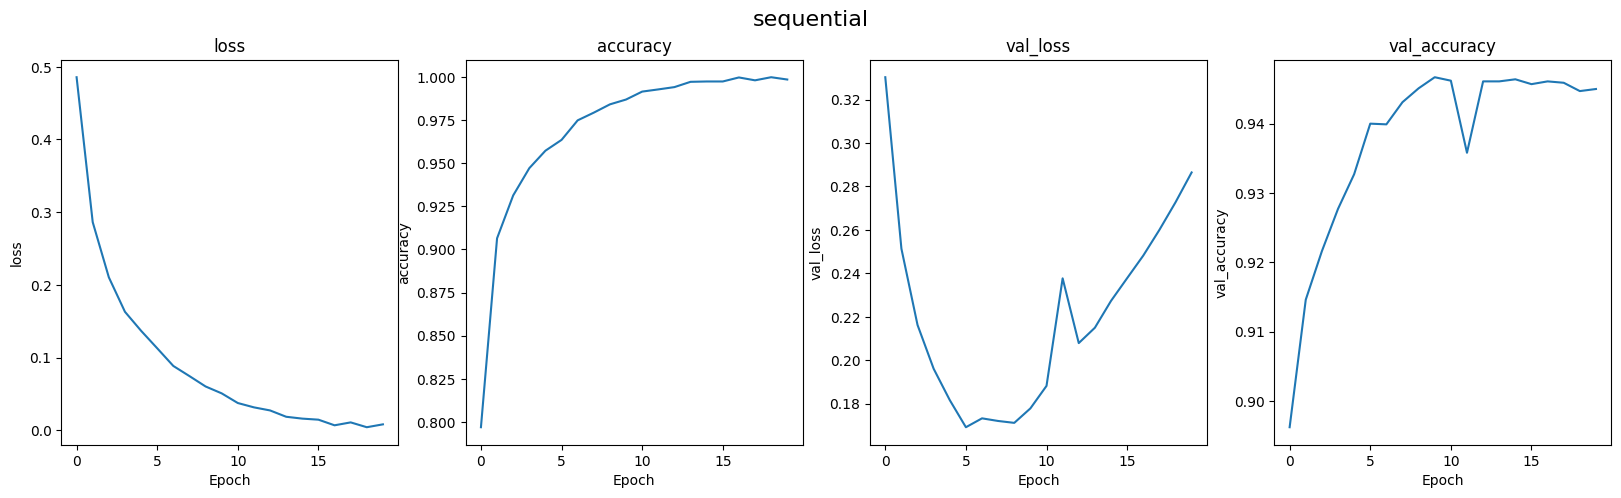

In [16]:
tensor_toolbox.draw_training_history(history=history)


In [17]:
epochs = 20
for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}")
    loss, accu = torchtrain(torchmodel, train_dataloader, optimizer, loss_fn)
    print(f"Train -- Accuracy: {accu} | Loss: {loss}")
    loss, accu = torchtest(torchmodel, val_dataloader, loss_fn)
    print(f"Validation -- Accuracy: {accu} | Loss: {loss}")

#TODO: Find a way to print more interesting output that takes less space.

Epoch 1/20
Train -- Accuracy: 0.7370666666666666 | Loss: 0.6112157995700837
Validation -- Accuracy: 0.8711 | Loss: 0.3175922405719757
Epoch 2/20
Train -- Accuracy: 0.9016666666666666 | Loss: 0.24886251456737518
Validation -- Accuracy: 0.8823 | Loss: 0.2861351694583893
Epoch 3/20
Train -- Accuracy: 0.9368666666666666 | Loss: 0.17713230335911115
Validation -- Accuracy: 0.8806 | Loss: 0.29858031578063965
Epoch 4/20
Train -- Accuracy: 0.9638666666666666 | Loss: 0.10141454988519351
Validation -- Accuracy: 0.8799 | Loss: 0.348565754365921
Epoch 5/20
Train -- Accuracy: 0.9764 | Loss: 0.07045509678423405
Validation -- Accuracy: 0.8791 | Loss: 0.39972504620552063
Epoch 6/20
Train -- Accuracy: 0.9854 | Loss: 0.046886634885768094
Validation -- Accuracy: 0.8738 | Loss: 0.4621594308853149
Epoch 7/20
Train -- Accuracy: 0.9656 | Loss: 0.1739605342487494
Validation -- Accuracy: 0.8792 | Loss: 0.38217355394363406
Epoch 8/20
Train -- Accuracy: 0.9906 | Loss: 0.03506569293687741
Validation -- Accuracy: 0

**Listing 4.8: Plotting the training and validation loss**

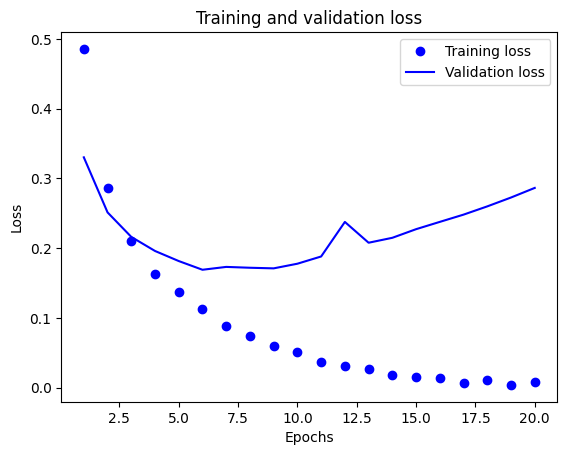

In [18]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Listing 4.9: Plotting the training and validation accuracy**

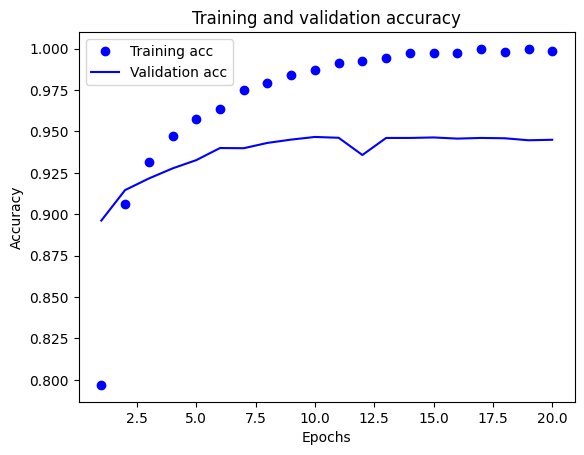

In [19]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Listing 4.10: Retraining a model from scratch**

In [20]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)), epochs=4, batch_size=512,
          callbacks=[TqdmCallback(verbose=1)], verbose=0)
results = model.evaluate(x_test, y_test)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

782/782 [==============================] - 0s 541us/step - loss: 0.3186 - accuracy: 0.8744


In [21]:
# Let's create a new dataloader to iterate over the whole training data (training+val) and
# another to iterate over the test data.
train_dataloader = tensor_toolbox.make_dataloader([x_train, x_val], [y_train, y_val], batch_size=512, shuffle=False)
test_dataloader = tensor_toolbox.make_dataloader([x_test], [y_test], batch_size=512, shuffle=False)
# The torch model peaks in validation metrics at the second iteration! That's actually crazy.
epochs = 2
# Re-initialize the model, optimizer and loss object:
torchmodel = TorchModel()
optimizer = torch.optim.RMSprop(torchmodel.parameters())
loss_fn = torch.nn.BCELoss() 

for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}")
    loss, accu = torchtrain(torchmodel, train_dataloader, optimizer, loss_fn)
    print(f"Train -- Accuracy: {accu} | Loss: {loss}")

loss, accu = torchtest(torchmodel, test_dataloader, loss_fn)
print(f"Test -- Accuracy: {accu} | Loss: {loss}") # Hell yeah! We happy

/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 1/2
Train -- Accuracy: 0.5062 | Loss: 1.0495133726119996
Epoch 2/2
Train -- Accuracy: 0.5686 | Loss: 0.6886625045776367
Test -- Accuracy: 0.7764 | Loss: 0.5789848280334473


### Using a trained model to generate predictions on new data

In [22]:
tensor_toolbox.tensor_info(model.predict(x_test), "Keras predictions")

782/782 [==============================] - 0s 437us/step
==================== Keras predictions | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (25000, 1) | nDims: 2 | dtype: float32
Content: [1.3077712e-01 9.9908990e-01 6.7013836e-01 6.2095636e-01 9.3199962e-01
 6.2911880e-01 9.9857688e-01 2.9880223e-03 9.3209517e-01 9.6303332e-01
 8.9919835e-01 3.7891800e-03 3.8891074e-05 1.1317553e-02 9.8426348e-01
 2.7555038e-06 8.1941819e-01 6.3465476e-01 1.0759056e-03 2.9207967e-02]
... (showing only the first 20 elements)



In [23]:
index = 751
print(read_review(train_data[index], word_index))
x = vectorize_sequences([test_data[index]])
yhat = model.predict(x)
print(f"Prediction: {'Positive'if yhat[0] > 0.5 else 'Negative'} | Confidence: {yhat[0]}")

? this is jackie chan's best film and my personal favourite after the disappointing u s made 'the ? directed by james ? jackie took the concept and placed it slap bang into hong kong this is also probably ? most violent movie with the audience cringing at the bone breaking stunts br br the action is fast and furious jackie and his crew really did put max effort into the fight design bones were broken and blood ? in the process of making this film as you'll see in the credits br br the script is a simple cops and robbers affair nothing special after all it was written around the action i must say that the english version has some dodgy dubbing but it shouldn't put you off too much br br so get the ? round crack open the beers and enjoy by the way the film was ? ? ? by the stunt crew why i'll let you find out for yourself
1/1 [==============================] - 0s 10ms/step
Prediction: Positive | Confidence: [0.93385845]


### Further experiments

In [24]:
# TODO: I would love to streamline this kind of network development. It gets kind of crammed...

In [25]:
model1 = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model1")
model1.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model2 = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model2")
model2.compile(optimizer="rmsprop",
              loss="mse",
              metrics=["accuracy"])

model3 = keras.Sequential([
    layers.Dense(16, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
], name="model3")
model3.compile(optimizer="rmsprop",
              loss="mse",
              metrics=["accuracy"])
model4 = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model4")
model4.compile(optimizer="rmsprop",
              loss="mse",
              metrics=["accuracy"])

model5 = keras.Sequential([
    layers.Dense(32, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
], name="model5")
model5.compile(optimizer="rmsprop",
              loss="mse",
              metrics=["accuracy"])

model6 = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
], name="model6")
model6.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])


In [26]:
# This function is kind of cool tho.
#tensor_toolbox.keras_comparer([model1, model2, model3, model4, model5, model6], X_train=x_train, y_train=y_train, X_test=x_test, y_test=y_test, val_data=(x_val, y_val), epochs=10, batch_size=512)

### Wrapping up

## Classifying newswires: A multiclass classification example

### The Reuters dataset

**Listing 4.11: Loading the Reuters dataset**

In [27]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)
# More list arrays. Ugh

**Listing 4.12: Decoding newswires back to text**

In [28]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in
    train_data[0]])
print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [29]:
tensor_toolbox.tensor_info(train_labels, "train_labels", image=False)
# Each category corresponds to a newswire topic.

==================== train_labels | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (8982,) | nDims: 1 | dtype: int64
Content: [ 3  4  3  4  4  4  4  3  3 16  3  3  4  4 19  8 16  3  3 21]
... (showing only the first 20 elements)



### Preparing the data

**Listing 4.13: Encoding the input data**

In [30]:
x_train = vectorize_sequences(train_data) # Same function as we used in the previous case
x_test = vectorize_sequences(test_data)
tensor_toolbox.tensor_info(x_train, "x_train", image=False)
tensor_toolbox.tensor_info(x_test, "x_test", image=False)
# As in the previous case, the concept of order is lost.

==================== x_train | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (8982, 10000) | nDims: 2 | dtype: float64
x_train[0]: [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1.]
... (showing only the first 20 elements)

==================== x_test | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (2246, 10000) | nDims: 2 | dtype: float64
x_test[0]: [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.]
... (showing only the first 20 elements)



**Listing 4.14: Encoding the labels**

In [31]:
def to_one_hot(labels, dimension=46): # 46 categories
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)
# Gets encoded into a 46-dimensional vector
tensor_toolbox.tensor_info(y_train, "y_train", image=False)

==================== y_train | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (8982, 46) | nDims: 2 | dtype: float64
y_train[0]: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
... (showing only the first 20 elements)



In [32]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)
tensor_toolbox.tensor_info(y_train, "y_train", image=False)
tensor_toolbox.tensor_info(y_test, "y_test", image=False)
# Scikit-learn has a similar function called LabelEncoder

==================== y_train | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (8982, 46) | nDims: 2 | dtype: float32
y_train[0]: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
... (showing only the first 20 elements)

==================== y_test | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (2246, 46) | nDims: 2 | dtype: float32
y_test[0]: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
... (showing only the first 20 elements)



### Building your model

**Listing 4.15: Model definition**

In [33]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.build(input_shape=(512, 10000))
model.summary() # That's some parameters

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (512, 64)                 640064    
                                                                 
 dense_22 (Dense)            (512, 64)                 4160      
                                                                 
 dense_23 (Dense)            (512, 46)                 2990      
                                                                 
Total params: 647214 (2.47 MB)
Trainable params: 647214 (2.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
from torch import nn
import torch.nn.functional as F # Contains the softmax function

class TorchModel (nn.Module):
    def __init__(self):
        super(TorchModel, self).__init__()
        # Using LazyLinears again. I could explicitly define the size.
        self.fc1 = nn.LazyLinear(64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 46)

    def forward(self, X):
        X = torch.relu(self.fc1(X))
        X = torch.relu(self.fc2(X))
        return self.fc3(X) # No activation function here!
        # CrossEntropyLoss in PyTorch expects raw logits, not probabilities.
    


In [35]:
torchmodel = TorchModel()
# This is pretty nice.
from torchsummary import summary
summary(torchmodel, input_size=(512, 10000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 512, 64]         640,064
            Linear-2              [-1, 512, 64]           4,160
            Linear-3              [-1, 512, 46]           2,990
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 19.53
Forward/backward pass size (MB): 0.68
Params size (MB): 2.47
Estimated Total Size (MB): 22.68
----------------------------------------------------------------


**Listing 4.16: Compiling the model**

In [36]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [37]:
# RMSprop, as in Keras.
# When you pass it model.parameters(), it gets the reference and knows
# how to update them. It's very cool. I'm such a fan of PyTorch.

optimizer = torch.optim.RMSprop(torchmodel.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

def torchtrain(train_dataloader, model, loss_fn, optimizer):
    model.train() # We're training you!
    total_loss = 0.0
    correct = 0
    samples = 0

    for X, y in train_dataloader:
        y_hat = model(X)
        loss = loss_fn(y_hat, y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Multiply by the batch size to get the total loss
        total_loss += loss.item()*len(y)

        predicted_labels = torch.argmax(y_hat, dim=1)
        true_labels = torch.argmax(y, dim=1)
        correct += (predicted_labels == true_labels).sum().item()
        samples += len(y)

    avg_loss = total_loss / len(train_dataloader.dataset)
    return avg_loss, correct / samples

def torchtest(test_dataloader, model, loss_fn):
    model.eval()
    total_loss = 0.0
    correct = 0
    samples = 0

    with torch.no_grad():
        for X, y in test_dataloader:
            y_hat = model(X)
            loss = loss_fn(y_hat, y)

            total_loss += loss.item()*len(y)

            predicted_labels = torch.argmax(y_hat, dim=1)
            true_labels = torch.argmax(y, dim=1)
            correct += (predicted_labels == true_labels).sum().item()
            samples += len(y)
            
    avg_loss = total_loss / len(test_dataloader.dataset)
    return avg_loss, correct / samples


### Validating your approach

**Listing 4.17: Setting aside a validation set**

In [38]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]
# With sklearn:
partial_x_train, x_val, partial_y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=1000)
# I'm not a big fan of the names, but it's aight.

In [39]:
# DataLoaders for torch:
train_dataloader = tensor_toolbox.make_dataloader([partial_x_train], [partial_y_train], batch_size=512, shuffle=False)
val_dataloader = tensor_toolbox.make_dataloader([x_val], [y_val], batch_size=512, shuffle=False)

**Annex: Propagations in PyTorch, Categorical Cross Entropy**

In [40]:
first_batch = next(iter(train_dataloader))
first_batch_input = first_batch[0]
first_batch_labels = first_batch[1]
tensor_toolbox.tensor_info(first_batch_input, "first_batch_input", image=False)
tensor_toolbox.tensor_info(first_batch_labels, "first_batch_labels", image=False)

==================== first_batch_input | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([512, 10000]) | nDims: 2 | dtype: torch.float32
first_batch_input[0]: tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
        0., 1.])
... (showing only the first 20 elements)

==================== first_batch_labels | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([512, 46]) | nDims: 2 | dtype: torch.float32
first_batch_labels[0]: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.])
... (showing only the first 20 elements)



In [41]:
first_batch_output = torchmodel(first_batch_input)
tensor_toolbox.tensor_info(first_batch_output, "first_batch_output", image=False)
first_batch_loss = loss_fn(first_batch_output, first_batch_labels)
# Average loss over the batch
tensor_toolbox.tensor_info(first_batch_loss, "first_batch_loss", image=False)

==================== first_batch_output | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([512, 46]) | nDims: 2 | dtype: torch.float32
first_batch_output[0]: tensor([-0.0330,  0.0141, -0.0363, -0.0935,  0.0777,  0.0345, -0.1060,  0.0954,
         0.0395, -0.0352, -0.0505, -0.0564,  0.0986, -0.0312,  0.1129, -0.0201,
        -0.0483, -0.0628, -0.0662, -0.0592], grad_fn=<SliceBackward0>)
... (showing only the first 20 elements)

==================== first_batch_loss | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([]) | nDims: 0 | dtype: torch.float32
Content: 3.8667898178100586



/Users/alemalvarez/code-workspace/dl-with-python-pytorch/tensor_toolbox.py:89: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  if(tensor.requires_grad and tensor.grad is not None):


In [42]:
# Let's compute the predictions to get the accuracy
first_batch_predictions = torch.argmax(first_batch_output, dim=1)
first_batch_true = torch.argmax(first_batch_labels, dim=1)
tensor_toolbox.tensor_info(first_batch_predictions, "first_batch_predictions", image=False)
tensor_toolbox.tensor_info(first_batch_true, "first_batch_true", image=False)
first_batch_correct = (first_batch_predictions == first_batch_true).sum()
tensor_toolbox.tensor_info(first_batch_correct, "first_batch_correct", image=False)


==================== first_batch_predictions | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([512]) | nDims: 1 | dtype: torch.int64
Content: tensor([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
        24, 24])
... (showing only the first 20 elements)

==================== first_batch_true | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([512]) | nDims: 1 | dtype: torch.int64
Content: tensor([11,  3,  9, 20, 30,  4,  3,  3,  6, 11,  3, 19,  4,  4,  0,  4, 16,  3,
         3,  4])
... (showing only the first 20 elements)

==================== first_batch_correct | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([]) | nDims: 0 | dtype: torch.int64
Content: 1



**Listing 4.18: Training the model**

In [43]:
from tqdm.keras import TqdmCallback
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[TqdmCallback(verbose=1)],
                    verbose=0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [44]:
epochs = 30
for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}")
    loss, accu = torchtrain(train_dataloader, torchmodel, loss_fn, optimizer)
    print(f"Train -- Accuracy: {accu} | Loss: {loss}")
    loss, accu = torchtest(val_dataloader, torchmodel, loss_fn)
    print(f"Validation -- Accuracy: {accu} | Loss: {loss}")


Epoch 1/30
Train -- Accuracy: 0.45088950137810074 | Loss: 3.2757529844409747
Validation -- Accuracy: 0.616 | Loss: 1.5371240644454955
Epoch 2/30
Train -- Accuracy: 0.6738912553244801 | Loss: 1.3459112854178343
Validation -- Accuracy: 0.718 | Loss: 1.159098328590393
Epoch 3/30
Train -- Accuracy: 0.7562014532698572 | Loss: 0.9194483238932065
Validation -- Accuracy: 0.752 | Loss: 1.031409791469574
Epoch 4/30
Train -- Accuracy: 0.8074417439238286 | Loss: 0.6809300561352679
Validation -- Accuracy: 0.761 | Loss: 0.9957971019744873
Epoch 5/30
Train -- Accuracy: 0.8480330744174392 | Loss: 0.5343751083098984
Validation -- Accuracy: 0.775 | Loss: 1.0000587120056152
Epoch 6/30
Train -- Accuracy: 0.8833625657729892 | Loss: 0.4113566933553997
Validation -- Accuracy: 0.773 | Loss: 1.0378781266212462
Epoch 7/30
Train -- Accuracy: 0.9041593585567527 | Loss: 0.33147905753149304
Validation -- Accuracy: 0.784 | Loss: 1.0778305649757385
Epoch 8/30
Train -- Accuracy: 0.9183162114758205 | Loss: 0.2811766075

**Listing 4.19: Plotting the training and validation loss**

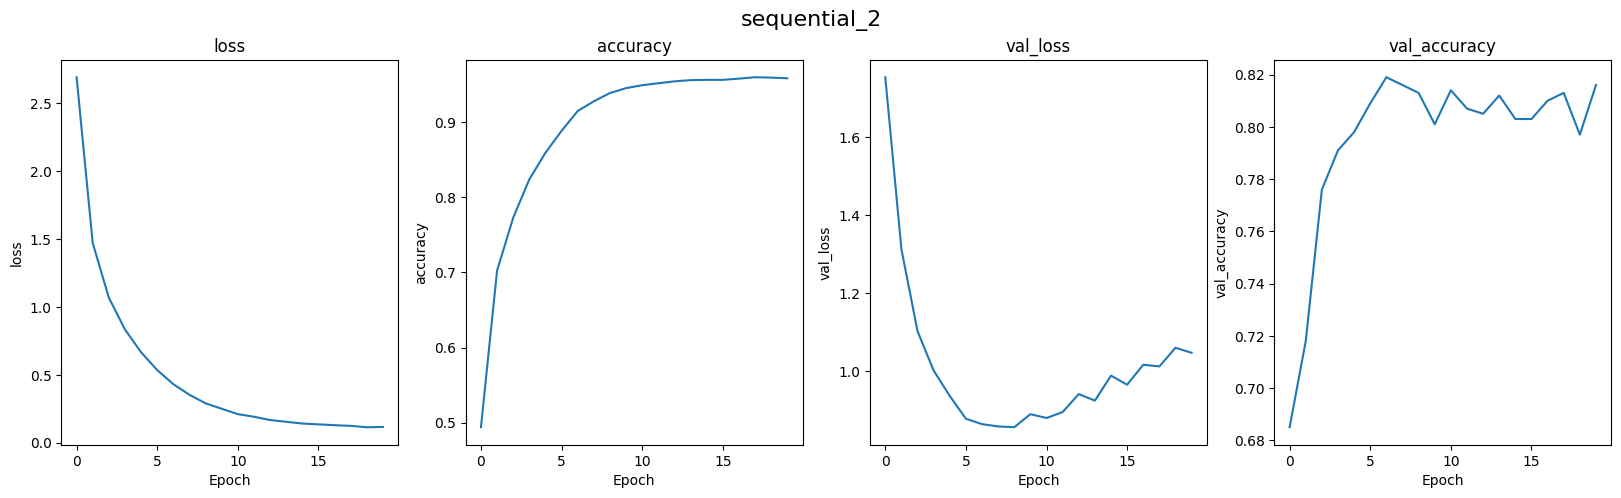

In [45]:
tensor_toolbox.draw_training_history(history=history)

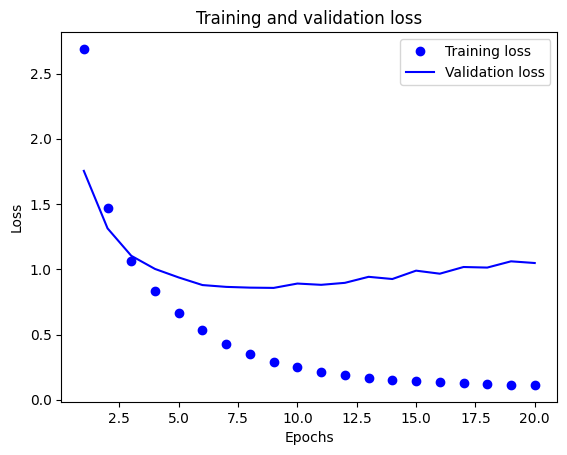

In [46]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Listing 4.20: Plotting the training and validation accuracy**

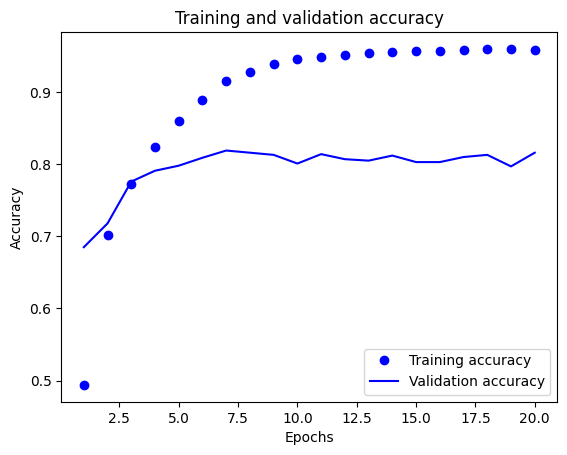

In [47]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Listing 4.21: Retraining a model from scratch**

In [48]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, # This x_train contains both the training and the validation sets. That's 
          # kind of annoying in my opinion.
          y_train,
          epochs=9,
          batch_size=512,
          callbacks=[TqdmCallback(verbose=1)],
          verbose=0)
results = model.evaluate(x_test, y_test)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

71/71 [==============================] - 0s 689us/step - loss: 0.9499 - accuracy: 0.7921


In [49]:
test_dataloader = tensor_toolbox.make_dataloader([x_test], [y_test], batch_size=512, shuffle=False)
train_dataloader = tensor_toolbox.make_dataloader([x_train], [y_train], batch_size=512, shuffle=False)

epochs = 29

torchmodel = TorchModel()
optimizer = torch.optim.RMSprop(torchmodel.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}")
    loss, accu = torchtrain(train_dataloader, torchmodel, loss_fn, optimizer)
    print(f"Train -- Accuracy: {accu} | Loss: {loss}")

loss, accu = torchtest(test_dataloader, torchmodel, loss_fn)
print(f"Test -- Accuracy: {accu} | Loss: {loss}")
# This time is slightly worse than in Keras. That bugs me, to be honest.

Epoch 1/29
Train -- Accuracy: 0.4704965486528613 | Loss: 3.156462012354448
Epoch 2/29
Train -- Accuracy: 0.6490759296370519 | Loss: 1.4295636198882191
Epoch 3/29
Train -- Accuracy: 0.7302382542863505 | Loss: 1.0435373346329373
Epoch 4/29
Train -- Accuracy: 0.7822311289245157 | Loss: 0.788783430044488
Epoch 5/29
Train -- Accuracy: 0.8217546203518148 | Loss: 0.6262870995073588
Epoch 6/29
Train -- Accuracy: 0.8482520596749054 | Loss: 0.518345636179813
Epoch 7/29
Train -- Accuracy: 0.8712981518592741 | Loss: 0.43397038373403524
Epoch 8/29
Train -- Accuracy: 0.8950122467156535 | Loss: 0.36147702219384836
Epoch 9/29
Train -- Accuracy: 0.9092629703852149 | Loss: 0.3067728398378961
Epoch 10/29
Train -- Accuracy: 0.9209530171454019 | Loss: 0.2680167863918981
Epoch 11/29
Train -- Accuracy: 0.9269650411934981 | Loss: 0.23946823856594887
Epoch 12/29
Train -- Accuracy: 0.9295257181028724 | Loss: 0.22125512987965865
Epoch 13/29
Train -- Accuracy: 0.9343130705856156 | Loss: 0.2049239412882471
Epoch 1

In [50]:
# Random classifier. What he doesn't take into account is that a dummy classifier would
# pick the most common class!
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

0.20391807658058772

In [51]:
# Count the appearances of each category in test_labels
from collections import Counter
counter = Counter(test_labels)
# Get the most common category
most_common = counter.most_common(1)[0][0]
# Get the accuracy of the dummy classifier
accuracy = counter[most_common] / len(test_labels)
accuracy
# Yea, that's the true baseline

0.3619768477292965

### Generating predictions on new data

In [52]:
keras_predictions = model.predict(x_test)
# Outputs have to be manually softmaxed in PyTorch if we want probabilities!
torch_predictions = F.softmax(torchmodel(torch.Tensor(x_test)), dim=1)

71/71 [==============================] - 0s 674us/step


In [53]:
tensor_toolbox.tensor_info(keras_predictions, "Keras predictions", image=False)
tensor_toolbox.tensor_info(torch_predictions, "Torch predictions", image=False)

==================== Keras predictions | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (2246, 46) | nDims: 2 | dtype: float32
Keras predictions[0]: [3.05482332e-04 8.83252709e-04 3.83642793e-04 5.06331503e-01
 4.17933196e-01 1.64827972e-04 7.35281676e-04 5.84057489e-05
 1.78112090e-02 7.95358937e-05 1.20434415e-04 2.63445615e-03
 1.13746864e-04 4.77247231e-04 1.93948654e-04 6.60627629e-05
 5.66274254e-03 7.06405437e-04 1.19955512e-03 1.48347870e-03]
... (showing only the first 20 elements)

==================== Torch predictions | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([2246, 46]) | nDims: 2 | dtype: torch.float32
Torch predictions[0]: tensor([1.6485e-08, 1.4096e-08, 5.1989e-23, 9.9924e-01, 1.5010e-04, 9.3706e-20,
        4.4912e-07, 1.5329e-08, 2.0549e-04, 4.6941e-08, 8.0897e-09, 2.7036e-05,
        5.5732e-06, 1.2307e-10, 4.9102e-18, 3.1651e-19, 1.1472e-07, 1.3769e-13,
        3.1764e-09, 1.9321e-06], grad_fn=<SliceBack

In [54]:
np.sum(keras_predictions[0])

1.0

In [55]:
# As expected, the sum of the probabilities is 1.
np.sum(torch_predictions[0].detach().numpy())   

1.0000001

In [56]:
newswire_index = 789

In [57]:
label_names = keras.datasets.reuters.get_label_names()
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in
    test_data[newswire_index]])
decoded_newswire

'? control data corp the computer concern is introducing its first department computer the ? 180 model 930 which will integrate a computer network starting with ? computers through its mainframe line to the supercomputer for control data it signals our intent to compete in our marketplace more completely than ever before said ? williams control ? vice president of computer systems one of six business units the large minneapolis based computer concern hit hard after two years of huge losses has said it anticipates a profitable year ahead but ? computer business has not been profitable since 1983 last year the company lost 264 5 mln dlrs including a fourth quarter restructuring charge of 139 9 mln dlrs and a one time loss of 69 mln dlrs we will use the 930 ? not only to ? and expand relationships with existing ? customers but also to create new sales opportunities for the corporation with businesses large and small said williams reuter 3'

In [58]:
print(f"Keras prediction: {label_names[np.argmax(keras_predictions[newswire_index])]}")
print(f"Torch prediction: {label_names[torch.argmax(torch_predictions[newswire_index])]}")
print(f"True label: {label_names[np.argmax(y_test[newswire_index])]}")

Keras prediction: earn
Torch prediction: earn
True label: earn


### A different way to handle the labels and the loss

In [59]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
# PyTorch CrossEntropyLoss already acceps the labels as integers. 
# I could make a PyTorch model that accepts the one-hot encoded labels, but
# I would have to redo the training function and I don't have time. Let's move forward.

In [60]:
tensor_toolbox.tensor_info(train_labels, "train labels")
tensor_toolbox.tensor_info(test_labels, "test labels")

==================== train labels | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (8982,) | nDims: 1 | dtype: int64
Content: [ 3  4  3  4  4  4  4  3  3 16  3  3  4  4 19  8 16  3  3 21]
... (showing only the first 20 elements)

==================== test labels | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (2246,) | nDims: 1 | dtype: int64
Content: [ 3 10  1  4  4  3  3  3  3  3  5  4  1  3  1 11 23  3 19  3]
... (showing only the first 20 elements)



### The importance of having sufficiently large intermediate layers

**A model with an information bottleneck**

In [61]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 1s 6ms/step - loss: 3.4940 - accuracy: 0.3280 - val_loss: 3.0917 - val_accuracy: 0.2980
Epoch 2/20
63/63 [==============================] - 0s 4ms/step - loss: 2.8205 - accuracy: 0.2985 - val_loss: 2.6995 - val_accuracy: 0.2910
Epoch 3/20
63/63 [==============================] - 0s 4ms/step - loss: 2.4419 - accuracy: 0.3125 - val_loss: 2.3954 - val_accuracy: 0.3020
Epoch 4/20
63/63 [==============================] - 0s 4ms/step - loss: 2.0553 - accuracy: 0.3369 - val_loss: 1.9594 - val_accuracy: 0.5110
Epoch 5/20
63/63 [==============================] - 0s 4ms/step - loss: 1.5134 - accuracy: 0.6581 - val_loss: 1.4850 - val_accuracy: 0.6420
Epoch 6/20
63/63 [==============================] - 0s 4ms/step - loss: 1.1994 - accuracy: 0.7020 - val_loss: 1.3604 - val_accuracy: 0.6800
Epoch 7/20
63/63 [==============================] - 0s 4ms/step - loss: 1.0624 - accuracy: 0.7383 - val_loss: 1.2987 - val_accuracy: 0.6980
Epoch 8/20
63/63 [==

### Further experiments

### Wrapping up

## Predicting house prices: A regression example

### The Boston Housing Price dataset

**Listing 4.23: Loading the Boston housing dataset**

In [62]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [63]:
tensor_toolbox.tensor_info(train_data, "train_data", image=False)
tensor_toolbox.tensor_info(train_targets, "train_targets", image=False)
tensor_toolbox.tensor_info(test_data, "test_data", image=False)
tensor_toolbox.tensor_info(test_targets, "test_targets", image=False)

==================== train_data | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (404, 13) | nDims: 2 | dtype: float64
train_data[0]: [  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]

==================== train_targets | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (404,) | nDims: 1 | dtype: float64
Content: [15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5]
... (showing only the first 20 elements)

==================== test_data | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (102, 13) | nDims: 2 | dtype: float64
test_data[0]: [ 18.0846   0.      18.1      0.       0.679    6.434  100.       1.8347
  24.     666.      20.2     27.25    29.05  ]

==================== test_targets | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (102,) | nDims: 1 | dtype: float64


### Preparing the data

**Listing 4.24: Normalizing the data**

In [64]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

# Or, in scikit:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# train_data = scaler.fit_transform(train_data)
# test_data = scaler.transform(test_data)

### Building your model

**Listing 4.25: Model definition**

In [65]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

In [66]:
# If you think about it, the class-oriented approach of PyTorch has already
# the 'model builder' mechanic into it. That's good.
class TorchModel(nn.Module):
    def __init__(self):
        super(TorchModel, self).__init__()
        self.fc1 = nn.LazyLinear(64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
    def forward(self, X):
        X = torch.relu(self.fc1(X))
        X = torch.relu(self.fc2(X))
        return self.fc3(X)

In [73]:
# I'm getting tired of always typing the same thing. I understand why they made Keras.
def torchtrain(train_dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0.0
    total_mae = 0.0
    samples = 0
    for X, y in train_dataloader:
        yhat = torch.flatten(model(X))
        loss = loss_fn(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*len(y)
        total_mae += torch.abs(yhat - y).sum().item()
        samples += len(y)
    avg_loss = total_loss / len(train_dataloader.dataset)
    avg_mae = total_mae / len(train_dataloader.dataset)
    return avg_loss, avg_mae

def torchtest(test_dataloader, model, loss_fn):
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    samples = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            yhat = torch.flatten(model(X))
            loss = loss_fn(yhat, y)
            total_loss += loss.item()*len(y)
            total_mae += torch.abs(yhat - y).sum().item()
            samples += len(y)
    avg_loss = total_loss / len(test_dataloader.dataset)
    avg_mae = total_mae / len(test_dataloader.dataset)
    return avg_loss, avg_mae

### Validating your approach using K-fold validation

**Listing 4.26: K-fold validation**

In [76]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = {
    "keras": [],
    "torch": []
}

for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    train_dataloader = tensor_toolbox.make_dataloader([partial_train_data], [partial_train_targets], batch_size=16, shuffle=False)
    val_dataloader = tensor_toolbox.make_dataloader([val_data], [val_targets], batch_size=16, shuffle=False)

    model = build_model()
    torchmodel = TorchModel()
    optimizer = torch.optim.RMSprop(torchmodel.parameters())
    loss_fn = torch.nn.MSELoss()

    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    
    for epoch in range(1, num_epochs+1):
        torchtrain(train_dataloader, torchmodel, loss_fn, optimizer)

    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores['keras'].append(val_mae)
    val_mse, val_mae = torchtest(val_dataloader, torchmodel, loss_fn)
    all_scores['torch'].append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [77]:
all_scores

{'keras': [1.970288872718811,
  2.541607618331909,
  2.445826768875122,
  2.3189613819122314],
 'torch': [2.6588436542171063,
  2.596504060348662,
  2.6117576750198213,
  2.520821996254496]}

In [78]:
print(f"Keras score: {np.mean(all_scores['keras'])} PyTorch score: {np.mean(all_scores['torch'])}")
# I'm so mad that the scores in PyTorch are always slightly worse. What am I missing?

Keras score: 2.3191711604595184 PyTorch score: 2.5969818464600216


**Listing 4.27: Saving the validation logs at each fold**

In [79]:
# This would be a pain in the ass to do in PyTorch, as it lacks the history object. I will eventually try to build
# something similar, but my god I don't feel like it.
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


**Listing 4.28: Building the history of successive mean K-fold validation scores**

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Listing 4.29: Plotting validation scores**

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Listing 4.30: Plotting validation scores, excluding the first 10 data points**

In [ ]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Listing 4.31: Training the final model**

In [ ]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

In [ ]:
test_mae_score

### Generating predictions on new data

In [ ]:
predictions = model.predict(test_data)
predictions[0]

### Wrapping up

## Summary